
# Tutorial 1 — Overall ML Pipeline (Wine Quality)

**Dataset:** `winequality-red.csv` or `winequality-white.csv` (UCI / Kaggle format; semicolon-separated)

**Learning objectives**
- See a full, *clean* ML pipeline end-to-end (regression + classification).
- Practice correct splitting/validation to prevent leakage and to detect overfitting.
- Interpret core metrics properly and relate them to problem framing.
- Record basic computational cost (training vs prediction time).
- Communicate results clearly and reproducibly (one strong figure + short interpretation).


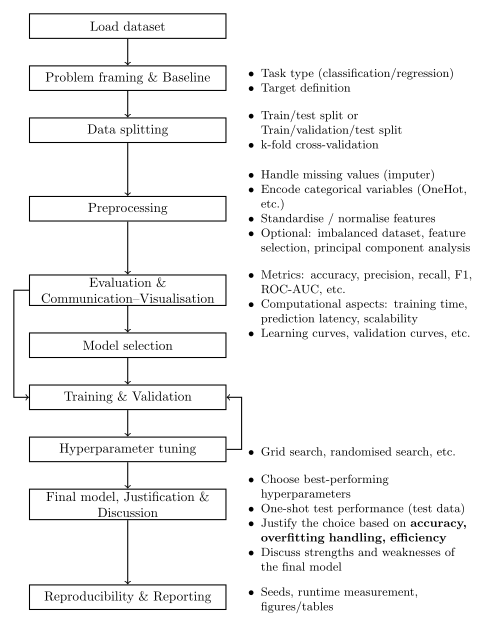

In [1]:
from IPython.display import display
import IPython.display as ipd

ipd.display(ipd.SVG(filename="ML_AI_pipeline.svg"))

## 1) Setup & imports

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# For reproducibility
RNG = 42
np.random.seed(RNG)



## 2) Load data

> Place `winequality-red.csv` or `winequality-white.csv` in the same folder as this notebook.  
Files are semicolon-separated (`sep=';'`). The target column is `quality`.


In [3]:

# Choose your file here:
DATA_PATH = r"winequality-red.csv" 

df = pd.read_csv(DATA_PATH, sep=";")
assert "quality" in df.columns, "Expected 'quality' column."
print(df.shape)
df.head()


(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 3) Quick sanity checks

In [4]:

display(df.describe(include='all'))
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False))


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000



Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


## 4) Regression: predict numeric quality

We will use **Ridge Regression**, which is linear regression with an added *L2 penalty*  
on the coefficients.  

It solves the following optimisation problem:

$
\min_{\beta_0, \beta} \; 
\sum_{i=1}^n \big(y_i - \beta_0 - \mathbf{x}_i^\top \beta \big)^2 
\;+\; \alpha \sum_{j=1}^p \beta_j^2
$

- The first term is the usual **least squares error**.  
- The second term is the **L2 regularisation** (penalty on large coefficients).  
- The hyperparameter $\alpha \geq 0$ controls the strength of the penalty:  
  - $\alpha = 0$ → ordinary least squares.  
  - Larger $\alpha$ → coefficients shrink more, reducing variance but adding bias.  

This makes Ridge regression more robust to multicollinearity and helps prevent overfitting.

In [5]:
X = df.drop(columns=["quality"])
y_reg = df["quality"]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=RNG
)

reg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0, random_state=RNG))
])

kf = KFold(n_splits=5, shuffle=True, random_state=RNG)
cv_reg = cross_validate(
    reg_pipe, X_train_r, y_train_r, cv=kf, n_jobs=-1,
    scoring=("r2", "neg_mean_squared_error", "neg_mean_absolute_error"),
    return_train_score=True
)

print(f"CV Mean R2 (train):  {cv_reg['train_r2'].mean():.3f} ± {cv_reg['train_r2'].std():.3f}")
print(f"CV Mean R2 (val):    {cv_reg['test_r2'].mean():.3f}  ± {cv_reg['test_r2'].std():.3f}")
print(f"CV Mean RMSE (val):  {np.mean(np.sqrt(-cv_reg['test_neg_mean_squared_error'])):.3f}")
print(f"CV Mean MAE (val):   {-cv_reg['test_neg_mean_absolute_error'].mean():.3f}")

t0 = time.time()
reg_pipe.fit(X_train_r, y_train_r)
train_time = time.time() - t0

t1 = time.time()
y_pred_r = reg_pipe.predict(X_test_r)
pred_time = time.time() - t1

rmse = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
mae = mean_absolute_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
print(f"Test RMSE: {rmse:.3f} | Test MAE: {mae:.3f} | Test R2: {r2:.3f}")
print(f"Train time: {train_time*1000:.1f} ms | Predict time: {pred_time*1000:.1f} ms")


CV Mean R2 (train):  0.350 ± 0.006
CV Mean R2 (val):    0.323  ± 0.031
CV Mean RMSE (val):  0.662
CV Mean MAE (val):   0.506
Test RMSE: 0.625 | Test MAE: 0.504 | Test R2: 0.403
Train time: 10.4 ms | Predict time: 4.0 ms


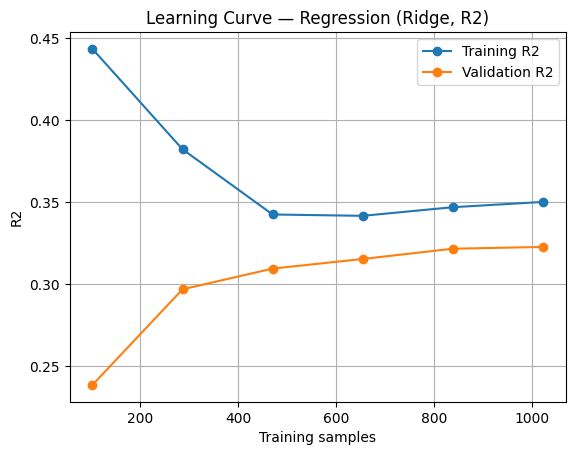

In [6]:
# Learning curve (Regression, R2)
train_sizes, train_scores, val_scores = learning_curve(
    reg_pipe, X_train_r, y_train_r, cv=kf, scoring="r2", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6), shuffle=True, random_state=RNG
)
plt.figure()
plt.title("Learning Curve — Regression (Ridge, R2)")
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training R2")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation R2")
plt.xlabel("Training samples"); plt.ylabel("R2"); plt.legend(); plt.grid(True)
plt.show()


## 5) Classification: predict good vs not-good wine

### Logistic Regression parameters explained

We use **Logistic Regression**, a linear model that predicts the probability of belonging  
to a class (here: good vs. not-good wine). It estimates parameters $\beta$ by minimising  
the *logistic loss* function with L2 regularisation (by default):

$$
\min_{\beta_0, \beta} 
\; - \frac{1}{n} \sum_{i=1}^n 
  \left[ y_i \log(\hat{p}_i) + (1 - y_i)\log(1 - \hat{p}_i) \right]
  + \frac{1}{2C} \sum_{j=1}^p \beta_j^2
$$

where $\hat{p}_i = \sigma(\beta_0 + \mathbf{x}_i^\top \beta)$  
and $\sigma(z) = \frac{1}{1 + e^{-z}}$ is the sigmoid function.

---

**Key parameters**

| Parameter | Meaning | Typical teaching note |
|------------|----------|------------------------|
| `max_iter=2000` | Maximum number of iterations for the solver to converge. | Increase this when the model reports *“did not converge”*. |
| `C=1.0` | Inverse of the regularisation strength ($C = 1/\lambda$). Smaller values → stronger regularisation. | Think of `C` as “how flexible” the model can be: high `C` = less penalty = possible overfitting. |
| `class_weight=None` | How to weight classes during training. `None` = treat all equally; `"balanced"` = auto-weight by class frequency. | Use `"balanced"` when your dataset has *class imbalance*. |
| `random_state=RNG` | Fixes the random seed for reproducibility (affects data shuffling and initialisation). | Ensures everyone gets identical results. |

---

In short:
- **Regularisation (via C)** controls overfitting just like Ridge.  
- **`max_iter`** ensures the optimiser runs long enough.  
- **`class_weight`** can correct imbalanced labels.  
- **`random_state`** guarantees reproducibility.


CV Mean Acc (train): 0.883 ± 0.001
CV Mean Acc (val):   0.879  ± 0.009
CV Mean F1 (val):    0.415
CV Mean ROC-AUC (val): 0.870
Test Accuracy: 0.894 | Test F1: 0.485 | Test ROC-AUC: 0.880
Train time: 14.4 ms | Predict time: 1.9 ms


<Figure size 640x480 with 0 Axes>

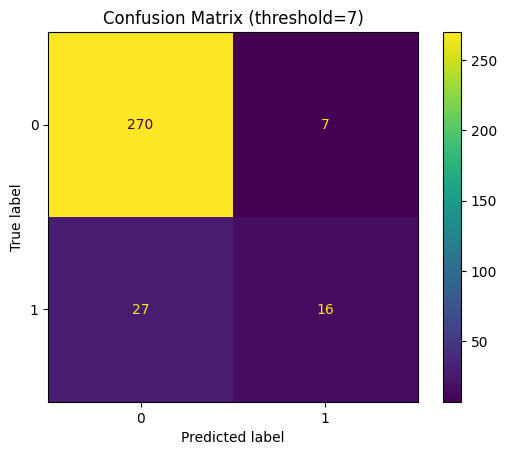

In [7]:

# Binary label from quality with an adjustable threshold
threshold = 7
y_clf = (df['quality'] >= threshold).astype(int)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_clf, test_size=0.2, stratify=y_clf, random_state=RNG
)

clf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=2000, C=1.0, class_weight=None, random_state=RNG))
])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
cv_clf = cross_validate(
    clf_pipe, X_train_c, y_train_c,
    cv=skf, scoring=("accuracy", "f1", "roc_auc"),
    return_train_score=True, n_jobs=-1
)

print(f"CV Mean Acc (train): {cv_clf['train_accuracy'].mean():.3f} ± {cv_clf['train_accuracy'].std():.3f}")
print(f"CV Mean Acc (val):   {cv_clf['test_accuracy'].mean():.3f}  ± {cv_clf['test_accuracy'].std():.3f}")
print(f"CV Mean F1 (val):    {cv_clf['test_f1'].mean():.3f}")
print(f"CV Mean ROC-AUC (val): {cv_clf['test_roc_auc'].mean():.3f}")

# Fit & evaluate on TEST
t0 = time.time()
clf_pipe.fit(X_train_c, y_train_c)
train_time = time.time() - t0

t1 = time.time()
y_proba = clf_pipe.predict_proba(X_test_c)[:, 1]
y_pred_c = (y_proba >= 0.5).astype(int)
pred_time = time.time() - t1

acc = accuracy_score(y_test_c, y_pred_c)
f1 = f1_score(y_test_c, y_pred_c, zero_division=0)
roc = roc_auc_score(y_test_c, y_proba)
print(f"Test Accuracy: {acc:.3f} | Test F1: {f1:.3f} | Test ROC-AUC: {roc:.3f}")
print(f"Train time: {train_time*1000:.1f} ms | Predict time: {pred_time*1000:.1f} ms")

# Confusion matrix
cm = confusion_matrix(y_test_c, y_pred_c)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure()
disp.plot(values_format='d')
plt.title(f"Confusion Matrix (threshold={threshold})")
plt.show()


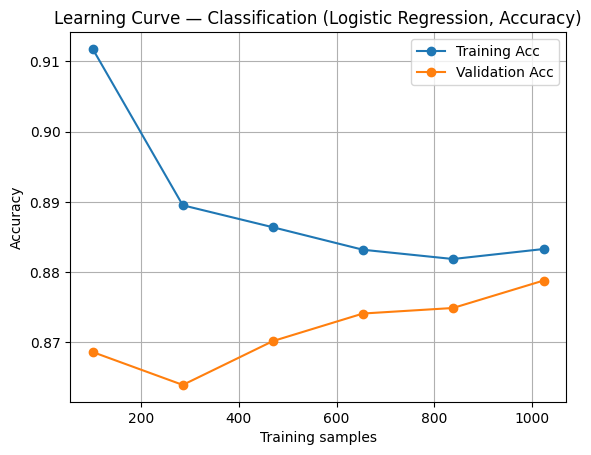

In [8]:
# Learning curve (Classification, Accuracy)
train_sizes, train_scores, val_scores = learning_curve(
    clf_pipe, X_train_c, y_train_c, cv=skf, scoring="accuracy", n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 6), shuffle=True, random_state=RNG
)
plt.figure()
plt.title("Learning Curve — Classification (Logistic Regression, Accuracy)")
plt.plot(train_sizes, train_scores.mean(axis=1), marker="o", label="Training Acc")
plt.plot(train_sizes, val_scores.mean(axis=1), marker="o", label="Validation Acc")
plt.xlabel("Training samples"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
plt.show()



---
## ⏱️ Tasks

**Task A — Metrics & thresholding (conceptual + operational)**  
1. **Label threshold:** change the definition of “good wine” to 6, 6.5, 7.5.  
   - Observe how this affects class balance (`y_clf.value_counts()`).
   - Re-run the model and compare Accuracy, F1, ROC-AUC.
2. **Decision threshold:** keep label threshold fixed (e.g. 7)  
   but change the cutoff for predicted probability in  
   `y_pred_c = (y_proba >= cutoff).astype(int)` for `cutoff` = 0.3, 0.5, 0.7.  
   - Observe how Accuracy, F1, and the confusion matrix change.  
3. **Discussion:** In one paragraph, discuss  
   - which label threshold gives a realistic definition of "good wine", and  
   - which probability cutoff gives the fairest trade-off between false positives and false negatives.

**Task B — Overfitting signals**  
1. Inspect the two learning curves. Are you seeing high bias or high variance?  
2. Add `PolynomialFeatures(degree=2)` to the regression pipeline **before** `Ridge`.  
   - Did validation R² improve? Did overfitting worsen? Explain briefly.

**Task C — Validation guardrails**  
1. Temporarily remove stratification from the classification split. What changes? Why?  
2. Increase CV folds to 10; report mean±std Accuracy. What does std tell you about stability?

**Task D — Computational cost vs performance**  
1. Time training & prediction for classification at sample fractions (20%, 40%, 60%, 80%, 100%).  
2. Plot runtime vs Accuracy; identify the “knee” (diminishing returns).

**Task E — One strong figure**  
1. Choose one figure (learning curve OR confusion matrix OR runtime–performance).  
2. Write a 2–3 sentence caption that interprets the result (not just restates it).


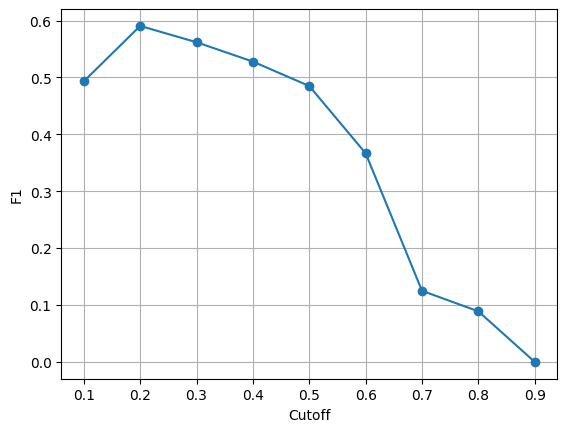

In [9]:
# Helper for Task A.2

from sklearn.metrics import f1_score
cutoffs = np.linspace(0.1, 0.9, 9)
scores = [f1_score(y_test_c, (y_proba >= c).astype(int)) for c in cutoffs]
plt.plot(cutoffs, scores, marker='o'); plt.xlabel("Cutoff"); plt.ylabel("F1"); plt.grid()


In [10]:
# Helper for Task D: runtime vs accuracy at different sample sizes
fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
results = []

for frac in fractions:
    # Stratified subsample of training data
    n = int(len(X_train_c) * frac)
    idx = np.random.choice(np.arange(len(X_train_c)), size=n, replace=False)
    X_sub, y_sub = X_train_c.iloc[idx], y_train_c.iloc[idx]

    pipe = Pipeline([("scaler", StandardScaler()),
                     ("model", LogisticRegression(max_iter=2000, random_state=RNG))])

    t0 = time.time()
    pipe.fit(X_sub, y_sub)
    t_train = time.time() - t0

    t1 = time.time()
    acc = pipe.score(X_test_c, y_test_c)  # accuracy on fixed test set
    t_pred = time.time() - t1

    results.append((frac, t_train, t_pred, acc))

results_df = pd.DataFrame(results, columns=["fraction", "train_time_s", "pred_time_s", "test_accuracy"])
results_df


,fraction,train_time_s,pred_time_s,test_accuracy
0,0.2,0.012367,0.003684,0.884375
1,0.4,0.010762,0.003959,0.884375
2,0.6,0.011531,0.003697,0.887500
3,0.8,0.010457,0.006022,0.884375
4,1.0,0.015858,0.002534,0.893750


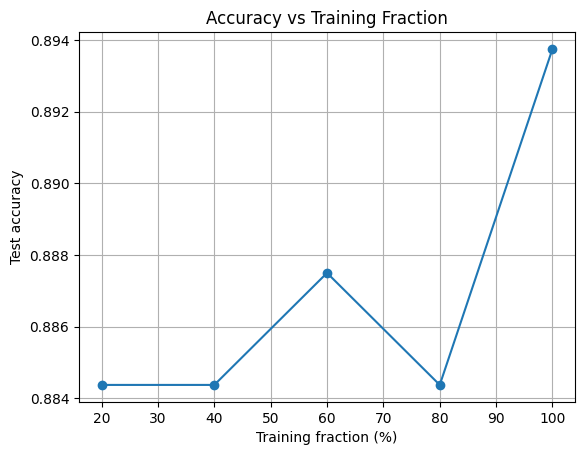

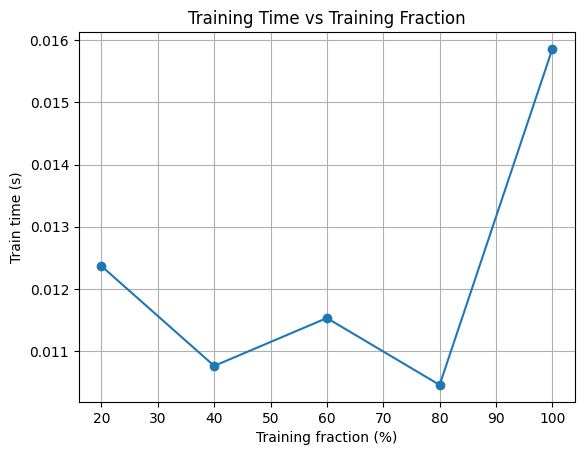

In [11]:
# Plot runtime vs accuracy
plt.figure()
plt.plot(results_df["fraction"]*100, results_df["test_accuracy"], marker="o")
plt.xlabel("Training fraction (%)"); plt.ylabel("Test accuracy")
plt.title("Accuracy vs Training Fraction")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(results_df["fraction"]*100, results_df["train_time_s"], marker="o")
plt.xlabel("Training fraction (%)"); plt.ylabel("Train time (s)")
plt.title("Training Time vs Training Fraction")
plt.grid(True)
plt.show()


## 6) Reproducibility & reporting

In [12]:

import sklearn, sys
print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)

print("\nPipelines used:")
print("Regression:", reg_pipe)
print("Classification:", clf_pipe)


Python: 3.14.0 (tags/v3.14.0:ebf955d, Oct  7 2025, 10:15:03) [MSC v.1944 64 bit (AMD64)]
NumPy: 2.3.4
Pandas: 2.3.3
scikit-learn: 1.7.2

Pipelines used:
Regression: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Ridge(random_state=42))])
Classification: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=2000, random_state=42))])



### Mini model card (fill in as a short paragraph)
- **Objective:** e.g., Predict wine quality (numeric) or classify “good wine” vs not-good.
- **Data:** Wine Quality (red/white), semicolon-separated; features are chemical properties.
- **Validation:** 5-fold CV on train; stratified split for classification; untouched test set.
- **Key metrics:** (Report your numbers concisely.)
- **Strengths / limitations:** (E.g., linear models, class imbalance at higher thresholds, etc.)
- **Ethical notes / misuse risks:** (Interpretation limits, applicability to different vintages, etc.)


## Appendix: (Optional) Quick Exploratory Data Analysis (EDA)

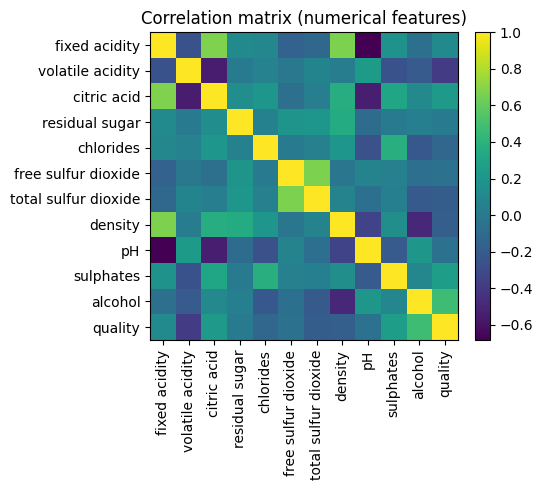

In [13]:

# Example: correlation matrix (numerical only)
corr = df.corr(numeric_only=True)
plt.figure(figsize=(6,5))
im = plt.imshow(corr.values, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Correlation matrix (numerical features)")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
